In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import scipy.stats as stats


# Préparation des données

In [2]:
df = pd.read_csv('world-happiness-report-2021.csv')
#df.head()
#df.info()
#df.describe()

df2 = pd.read_csv('world-happiness-report.csv')
df2.head()

#Création liste des régions du monde par pays
country_region = df.iloc[:,0:2]

#Mise en forme des 2 datasets en prévision du concat
#dataset de 2021 :
df_1 = df.iloc[:,:12]
df_1 = df_1.drop(df.iloc[:,3:6], axis=1)
df_1 = df_1.drop('Regional indicator', axis=1)
df_1['year']='2021'

#dataset historique depuis 2005 :
df_2 = df2.iloc[:, :-2]
dico = {'Life Ladder' : 'Ladder score', 'Log GDP per capita' : 'Logged GDP per capita', 'Healthy life expectancy at birth' : 'Healthy life expectancy'}
df_2.rename(dico, axis=1, inplace=True)

#création du fichier contenants les données depuis 2005 :
df_full = pd.concat([df_1, df_2], axis=0)
df_full['year'] = df_full['year'].astype('int')
df_full = df_full.sort_values(by='Country name', ascending=True)

#ajout colonne Region d'après le df country_region créé précédemment :
df_full = df_full.merge(country_region, on = 'Country name', how ='inner')

#ajout du rank par année de chaque pays
df_full["rank"] = df_full.groupby("year")["Ladder score"].rank("dense", ascending=False).astype('int')

df_full.head()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 0 to 2034
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  2035 non-null   object 
 1   Ladder score                  2035 non-null   float64
 2   Logged GDP per capita         2011 non-null   float64
 3   Social support                2026 non-null   float64
 4   Healthy life expectancy       1984 non-null   float64
 5   Freedom to make life choices  2005 non-null   float64
 6   Generosity                    1959 non-null   float64
 7   Perceptions of corruption     1931 non-null   float64
 8   year                          2035 non-null   int32  
 9   Regional indicator            2035 non-null   object 
 10  rank                          2035 non-null   int32  
dtypes: float64(7), int32(2), object(2)
memory usage: 174.9+ KB


# Régression linéaire sur df_full

Notre objectif est de pouvoir définir le score d'un pays d'après les 6 variables de l'étude.
Cela permettra d'établir le score d'un nouveau pays ou d'en analyser évolution en modifiant ses valeurs.

Nous avons donc opté pour une régression comme première itération. 



In [3]:
df_full.head()

,Country name,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,Regional indicator,rank
0,Afghanistan,4.402,7.540,0.552,51.20,0.679,0.190,0.850,2009,South Asia,91
1,Afghanistan,3.131,7.718,0.526,52.88,0.509,0.104,0.871,2014,South Asia,135
2,Afghanistan,3.983,7.702,0.529,53.20,0.389,0.080,0.881,2015,South Asia,121
3,Afghanistan,4.220,7.697,0.559,53.00,0.523,0.042,0.793,2016,South Asia,114
4,Afghanistan,2.662,7.697,0.491,52.80,0.427,-0.121,0.954,2017,South Asia,142


In [4]:
#Remplacement des NaN par les moyennes des variables en fonction de chaque pays
for i in df_full.iloc[:,2:8].columns : 
    df_full[i] = df_full[i].fillna(df_full.groupby('Country name')[i].transform("mean"))

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 0 to 2034
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  2035 non-null   object 
 1   Ladder score                  2035 non-null   float64
 2   Logged GDP per capita         2035 non-null   float64
 3   Social support                2035 non-null   float64
 4   Healthy life expectancy       2035 non-null   float64
 5   Freedom to make life choices  2035 non-null   float64
 6   Generosity                    2035 non-null   float64
 7   Perceptions of corruption     2035 non-null   float64
 8   year                          2035 non-null   int32  
 9   Regional indicator            2035 non-null   object 
 10  rank                          2035 non-null   int32  
dtypes: float64(7), int32(2), object(2)
memory usage: 174.9+ KB


In [6]:
## variable cile

target_full = df_full['Ladder score']

#df pour la rl

col_feat = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']



rlm_df_full = df_full[col_feat]



In [7]:
X_train, X_test, y_train, y_test = train_test_split(rlm_df_full, target_full, test_size=0.2, random_state=10)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

LinearRegression()

In [8]:
print('Coef de détermination du modèle :', lr.score(X_train_scaled, y_train))

print('Coef de détermination obtenu par cv :', cross_val_score(lr, X_train_scaled, y_train).mean())

print('Score test :', lr.score(X_test_scaled, y_test))

Coef de détermination du modèle : 0.7287878256957533
Coef de détermination obtenu par cv : 0.7267393495228369
Score test : 0.7672900793406261


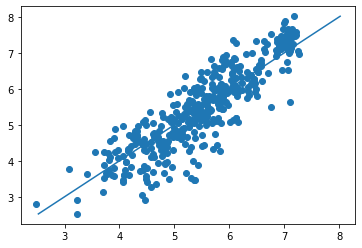

In [9]:
pred_test = lr.predict(X_test_scaled)
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()));

On obtient un score de ~77% avec ce modèle. 


### Recherche des variables significatives avec SelectFromModel :


In [10]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(lr)

sfm_train = sfm.fit_transform(X_train_scaled, y_train)

sfm_test = sfm.transform(X_test_scaled)

In [11]:
significant_feat = rlm_df_full.columns[sfm.get_support()]

significant_feat

Index(['Logged GDP per capita', 'Social support'], dtype='object')

In [12]:
lr2 = LinearRegression()

lr2.fit(X_train[significant_feat], y_train)



LinearRegression()

In [13]:
print('score train :', lr2.score(X_train[significant_feat], y_train))
print('score test :', lr2.score(X_test[significant_feat], y_test))

score train : 0.6609088737338665
score test : 0.7017327007194141


En entrainant le modèle sur ces 2 variables indiquées par le SelectFromModel ('Logged GDP per capita' et 'Social support') on obtient un score sur l'échantillon de test de ~70%.

### Recherche des variables significatives avec SelectKBest

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression

sk = SelectKBest(f_regression, k=3)

sk.fit(X_train, y_train)

significant_feat = rlm_df_full.columns[sk.get_support()]




In [15]:
lr2 = LinearRegression()

lr2.fit(X_train[significant_feat], y_train)

LinearRegression()

In [16]:
print('score train :', lr2.score(X_train[significant_feat], y_train))
print('score test :', lr2.score(X_test[significant_feat], y_test))

score train : 0.6746667237232329
score test : 0.717184172560545


Avec ces 3 variables sélectionnées par SelectKBest : ['Logged GDP per capita', 'Social support', 'Healthy life expectancy'] score_test ~72%

# Conclusion Itération 1

La Régression Linéaire incluant l'ensemble des 6 variables est la plus performante, avec un score avoisinnant les 77%.

Nous avons également testé les régressions linéaires régularisées vues en cours (Ridge, Lasso et Elastic Net), les scores obtenus étaient toujours inférieurs à ceux de la Régression linéraire multiple.
